In [1]:
import torch
import torchvision
import numpy as np 
from PIL import Image
import onnxruntime as ort 
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [2]:
IMAGE_SIZE = 640
class_names = ["cat", "duck"]
model_path = "yolov5_custom.onnx"

In [3]:
def to_tensor(image_path: str) :
    transformer = T.Compose([T.Resize((IMAGE_SIZE, IMAGE_SIZE))])
    image = torchvision.io.read_image(image_path).type(torch.float32) / 255.
    image_transform = transformer(image)
    return image, image_transform.to("cpu")

def infer_onnx_model(model_path, input_data):
    session = ort.InferenceSession(model_path)
    # Convert input data to a format that can be fed into the model
    input_name = session.get_inputs()[0].name
    input_data = {input_name: np.array(input_data, dtype=np.float32)}
    output = session.run(None, input_data)
    return output

In [16]:
image_path = "test-image4.jpg"
original_image, image_tensor = to_tensor(image_path)
original_image.shape, image_tensor.shape

(torch.Size([3, 508, 1066]), torch.Size([3, 640, 640]))

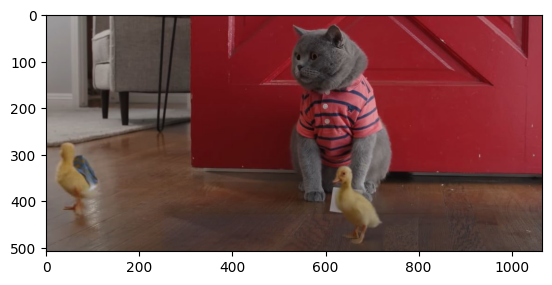

In [5]:
plt.imshow(original_image.permute(1, 2, 0))
plt.axis(True);

In [6]:
predict = infer_onnx_model(model_path, image_tensor.reshape(1, 3, IMAGE_SIZE, IMAGE_SIZE))
len(predict), predict[0].shape

(1, (1, 25200, 7))

In [7]:
predict = predict[0]

In [8]:
predict.shape

(1, 25200, 7)

In [9]:
from yolov5.utils.general import non_max_suppression, xyxy2xywh

out = non_max_suppression(torch.from_numpy(predict), conf_thres=0.3)[0]
out

tensor([[6.59106e+00, 3.24601e+02, 7.16683e+01, 5.58266e+02, 7.96234e-01, 1.00000e+00],
        [3.63656e+02, 4.07397e+02, 4.41350e+02, 6.23376e+02, 6.84016e-01, 1.00000e+00],
        [3.04330e+02, 9.07269e+01, 4.43868e+02, 4.43800e+02, 4.38000e-01, 0.00000e+00]])

In [10]:
xyxy = out[:,:4]
xywh = xyxy2xywh(xyxy)
out[:, :4] = xywh
out

tensor([[3.91297e+01, 4.41434e+02, 6.50772e+01, 2.33665e+02, 7.96234e-01, 1.00000e+00],
        [4.02503e+02, 5.15386e+02, 7.76935e+01, 2.15980e+02, 6.84016e-01, 1.00000e+00],
        [3.74099e+02, 2.67263e+02, 1.39539e+02, 3.53073e+02, 4.38000e-01, 0.00000e+00]])

In [11]:
import matplotlib.patches as patches

def draw_bbox_on_image(image, bboxes, color='r', save_path=None):
    image = image.permute(1, 2, 0)
    fig, ax = plt.subplots()
    ax.imshow(image)
    color_class = ["black", "blue"]
    # (x, y): from center
    # but matplotlib start from top-left
    for boxes in bboxes :
        x, y, w, h, probas, class_idx = boxes
        text = f"{class_names[class_idx]}: {probas}"
        top_left_x = x-w//2
        top_left_y = y-h//2
        rect = patches.Rectangle((top_left_x, top_left_y), w, h, linewidth=1, edgecolor=color_class[class_idx], facecolor='none')
        plt.text(top_left_x, top_left_y-10, text, fontsize=10, color=color_class[class_idx])
        ax.add_patch(rect)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # Close the figure to prevent displaying it
        print(f"saved: {save_path}")
    else:
        plt.show()

In [12]:
def rescale_bbox(boxes, input_shape):
    x, y, w, h, probas, class_idx = boxes
    # Calculate scaling factors
    scale_x = input_shape[2] / IMAGE_SIZE
    scale_y = input_shape[1] / IMAGE_SIZE

    # Rescale bounding box coordinates
    x_rescaled = x * scale_x
    y_rescaled = y * scale_y
    w_rescaled = w * scale_x
    h_rescaled = h * scale_y

    return x_rescaled, y_rescaled, w_rescaled, h_rescaled, round(float(probas), 2), int(class_idx)

In [13]:
if out.shape[0] != 0 :    
    print(f"Output boxes: {out[0]}")
    rescale_boxes = rescale_bbox(out[0], original_image.shape)
    print(f"Rescale boxes: {rescale_boxes}")

Output boxes: tensor([ 39.12967, 441.43369,  65.07721, 233.66473,   0.79623,   1.00000])
Rescale boxes: (tensor(65.17535), tensor(350.38797), tensor(108.39423), tensor(185.47137), 0.8, 1)


In [14]:
if out.shape[0] != 0 :
    rescale_bboxes = [rescale_bbox(boxes, original_image.shape) for boxes in out]
    draw_bbox_on_image(original_image, rescale_bboxes, save_path="test.jpg")

saved: test.jpg


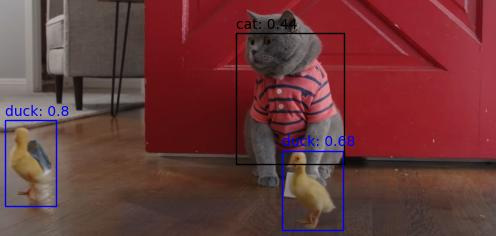

In [15]:
Image.open("test.jpg")